In [1]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Topic Modelling using LSA and LDA

This is an assignment for the course Computational Semantics at the University Paris Cite'. 

In this assignment, we use two topic modelling methods.
The goal of topic modelling is to describe a set of documents in terms of a set of topics (unknown a priori) such that each document is more or less strongly correlated with each topic and that each topic is more or less strongly correlated with each element of the vocabulary ("form", or "word").

More specifically, we use here the scikit-learn library to train and then analyse a Latent Semantic Analysis (LSA) model and a Latent Dirichlet Allocation (LDA) model.

We use a "real" dataset consisting of the English subtitles of the *Game of Thrones* TV series but also an artificial dataset this is particularly well suited to topic modelling.
This artificial dataset is useful to test the code and have an idea of the results of the different methods in an ideal case.

In [2]:
use_controlled_dataset = False
#use_controlled_dataset = False

# Creation of a controlled dataset

In order to more easily test the topic modelling methods that we are about to implement, we here create an artificial dataset consisting of "texts" that we know correspond to a mixture of well-defined "topics".
A topic modelling algorithm should be able to recognise the topics in these documents fairly well.

The topics are coded as the integer from 0 to `(n_artificial_topics-1)` (i.e. 15), or, equivalently, the letters from "A" (for 0) to "P" (for 15).
Each topic is associated a small set of forms, all obtained by repeating the letter corresponding to the topic (e.g. "B" or "BBB" for topic "B").
Each of the `n_docs=40` documents is assigned a topic `main_topic` and consists of `doc_length=2000` tokens. These tokens are not neccessarily occurrences of a form associated with `main_topic`, but each is an occurrence of a form associated with a topic selected randomly with a probability decreasing with the distance between the topic and `main_topic`.

For instance, the eighth document (named "doc_C_7") is assigned topic "C"; it is therefore likely to contain a lot of tokens in "C", a bit less of tokens in "B" or "D", a bit less of tokens in "A" or "E", etc.

The dataset is encoded as a list `dataset` that contains each document as a dictionary.
This dictionary contains:
*   an identifier (*str_id*) of the form "doc_x_yy" for "x" is the letter of its main topic and "yy" is a unique numerical identifier for the document;
*   a string (*raw_text*), the content of the document.

In [3]:
import numpy as np
import random

if(use_controlled_dataset):
  n_docs = 40 # Number of documents.
  doc_length = 2000 # Length of each document.
  n_topics = 10 # Number of topics.

  # Returns a character.
  # topic: int
  def topic_to_letter(topic):
    return chr(65 + topic) # 65 corresponds to "A".

  dataset = []
  for i in range(n_docs): # For each document.
    main_topic = int(i  * n_topics / n_docs) # Main topic of the document.
    print(f"{topic_to_letter(main_topic)} ({main_topic})", end=", ", flush=True)

    tokens = [] # list[str]
    for j in range(doc_length): # For each token.
      # Selects a topic for the token, likely to be `main_topic`, or one very near.
      topic = main_topic + int(np.random.randn() * 1.5)
      while(topic < 0): topic += n_topics
      topic = topic % n_topics

      # Generates the token.
      #token_length = np.floor(1 + 8 * np.random.uniform()) # Between 1 and 8.
      token_length = np.floor(9 - 8 * np.power(np.random.uniform(), 2)) # Between 1 and 8; more likely to be large than small.
      token = topic_to_letter(topic) * int(token_length)

      tokens.append(token)
    
    dataset.append({"str_id": f"doc_{topic_to_letter(main_topic)}_{i:02}", "raw_text": " ".join(tokens)})
else:
  print("[controlled dataset not in use]")

[controlled dataset not in use]


In [4]:
if(use_controlled_dataset):
  print(dataset[-1]["str_id"]) # Name of the last artificial document.
else:
  print("[controlled dataset not in use]")

[controlled dataset not in use]


In [5]:
if(use_controlled_dataset):
  print(dataset[7]["str_id"]) # Name of the 8th artificial document.
  print(dataset[7]["raw_text"]) # Text of the 8th artificial document. It should be composed mainly of tokens in C, then tokens in B or D, then tokens in A or E, etc.
else:
  print("[controlled dataset not in use]")

[controlled dataset not in use]


# Getting the Game of Thrones dataset

## Downloading and extracting the dataset

In [6]:
import os
import urllib # To download files.
import zipfile # To unzip files.

zip_url = "https://moodle.u-paris.fr/mod/resource/view.php?id=781987"
zip_filename = "data.zip"
data_dirname = zip_filename.split(".")[0] # Name of the directory in which the dataset is/will be.

if(not use_controlled_dataset):
  if(os.path.isdir(data_dirname)):
    print("Dataset found.")
  else:
    # Downloads the dataset.
    tmp = urllib.request.urlretrieve(zip_url)
    filename = tmp[0]
    print(f"Dataset downloaded to '{filename}'.")
    
    # Extracts the dataset.
    with zipfile.ZipFile(filename, 'r') as zip_ref:
      zip_ref.extractall(".", )
    assert os.path.isdir(data_dirname)
    print(f"Dataset extracted to '{data_dirname}'.")
else:
  print("[controlled dataset in use]")

Dataset downloaded to 'C:\Users\Wazzat\AppData\Local\Temp\tmpv6icb6sq'.
Dataset extracted to 'data'.


In [7]:
if(not use_controlled_dataset):
  print(dataset[-1]["str_id"]) # Name of the last document.
else:
  print("[controlled dataset in use]")

NameError: name 'dataset' is not defined

## Reading the Game of Thrones dataset

The dataset contains one SRT file per episodes of the Game of Thrones series, grouped by season (one subdirectory per season).

(The syntax of STR files is described here: https://docs.fileformat.com/video/srt/)

As for the artificial dataset, this dataset is encoded as a list `dataset` that contains each document as a dictionary.
This dictionary contains:
*   an identifier (*str_id*) of the form "doc_x_yy" for "x" is the letter of its main topic and "yy" is a unique numerical identifier for the document;
*   a string (*raw_text*), the concatenation of the subtitles of the corresponding episode.

In [ ]:
if(not use_controlled_dataset):
  dataset = [] # This will be a list of dictionaries.

  # file_path: str
  # Returns a string.
  def read_srt_file(file_path):
      lines = []
      with open(file_path) as f:
          c = True
          while(c):
              s = f.readline() # This should be the end of the file, an empty line or a number.
              if(s == ""): c = False # The end of the file has been reached.
              if(s.strip() == ""): continue # End of the file or empty line.

              f.readline() # We can throw away the timing that follows.

              # All the next non-empty lines are character lines.
              s = f.readline().strip()
              while(s != ""):
                  if(not s.startswith("#")): lines.append(s) # Ignores lines that start with '#'.
                  s = f.readline().strip()
      
      return ' '.join(lines)

  for path, dirs, files in os.walk(data_dirname): # Iterates through every subdirectories.
      path_parts = path.split(os.path.sep)
      if(len(path_parts) == 1): # If we are in the root directory.
        continue # There is no subtitle file in the root directory, only some 'info.txt' file.
      season = path_parts[1] # 'Sxx' where 'xx' is the season number.
      #print(season)

      for file in files:
          file_parts = file.replace(' ', '.').split(".") # Most files have a name that starts with 'Game.of.Thrones.SxxEyy.' where 'xx' is the season number and 'yy' the episode number, but some filenames use ' ' instead of '.'.
          str_id = file_parts[3] # 'SxxEyy' where 'yy' is the episode number.
          print(str_id, end= ", ")
          
          file_path = os.path.join(path, file)
          #print(file_path)
          
          dataset.append({"str_id": str_id, "raw_text": read_srt_file(file_path)})
else:
  print("[controlled dataset in use]")

S01E01, S01E02, S01E03, S01E04, S01E05, S01E06, S01E07, S01E08, S01E09, S01E10, S02E01, S02E02, S02E03, S02E04, S02E05, S02E06, S02E07, S02E08, S02E09, S02E10, S03E01, S03E02, S03E03, S03E04, S03E05, S03E06, S03E07, S03E08, S03E09, S03E10, S04E01, S04E02, S04E03, S04E04, S04E05, S04E06, S04E07, S04E08, S04E09, S04E10, S05E01, S05E02, S05E03, S05E04, S05E05, S05E06, S05E07, S05E08, S05E09, S05E10, S06E01, S06E02, S06E03, S06E04, S06E05, S06E06, S06E07, S06E08, S06E09, S06E10, S07E01, S07E02, S07E03, S07E04, S07E05, S07E06, S07E07, s08e01, s08e02, s08e03, s08e04, s08e05, s08e06, 

In [ ]:
if(not use_controlled_dataset):
  dataset = sorted(dataset, key=(lambda x: x["str_id"])) # Sorts the episode chronologically (via their season and episode number).

  for episode in dataset: print(episode["str_id"], end=", ")
else:
  print("[controlled dataset in use]")

S01E01, S01E02, S01E03, S01E04, S01E05, S01E06, S01E07, S01E08, S01E09, S01E10, S02E01, S02E02, S02E03, S02E04, S02E05, S02E06, S02E07, S02E08, S02E09, S02E10, S03E01, S03E02, S03E03, S03E04, S03E05, S03E06, S03E07, S03E08, S03E09, S03E10, S04E01, S04E02, S04E03, S04E04, S04E05, S04E06, S04E07, S04E08, S04E09, S04E10, S05E01, S05E02, S05E03, S05E04, S05E05, S05E06, S05E07, S05E08, S05E09, S05E10, S06E01, S06E02, S06E03, S06E04, S06E05, S06E06, S06E07, S06E08, S06E09, S06E10, S07E01, S07E02, S07E03, S07E04, S07E05, S07E06, S07E07, s08e01, s08e02, s08e03, s08e04, s08e05, s08e06, 

In [ ]:
if(not use_controlled_dataset):
  print(f'{dataset[0]["str_id"]}:')
  print(dataset[0]["raw_text"][:200]) # Beginning of the first episode.
  print("[…]")
  print(dataset[0]["raw_text"][-200:]) # End of the first episode.
else:
  print("[controlled dataset in use]")

S01E01:
Easy, boy. What do you expect? They're savages. One lot steals a goat from another lot, before you know it they're ripping each other to pieces. I've never seen wildlings do a thing like this. I never
[…]
saw us. - It's all right, it's all right. - It's all right. - He saw us! I heard you the first time. Quite the little climber, aren't you? - How old are you, boy? - Ten. Ten. The things I do for love.


# Preprocessing

In this subsection, the dictionnary for each document is enriched, most notably with *processed_tokens*, a list of tokens that will later be converted into a bag-of-words vector.

This list is obtained from the subtitles through a few steps: (i) normalisation/simplification of the text, (ii) tokenisation, (iii) filtering of stop words (i.e. words that are mostly irrelevant to the problem; in our case — topic modelling —, stop words are typically determiners, coordinating or subordinating conjunctions, but others are possible.).

This bloc of code defines, if necessary, the set of stop words (`stopwords`) used afterwards.

In [ ]:
if(use_controlled_dataset):
  filter_stopwords = False
else:
  filter_stopwords = True
  #filter_stopwords = False

language = "english"
#language = "french"

import nltk

if(filter_stopwords):
  try:
      print(f"NLTK stop words: {nltk.corpus.stopwords.words(language)}") # This might fail if "stopwords" is missing.
  except:
      nltk.download('stopwords')
      print(f"NLTK stop words: {nltk.corpus.stopwords.words(language)}")

  stopwords = set()
  stopwords.update(set(nltk.corpus.stopwords.words(language)))

  # Additional stop words.
  if(language == "english"): stopwords.update({})
  elif(language == "french"): stopwords.update({"a", "si", "plus", "fait", "faire", "ça", "tout", "tous", "toute", "toutes", "ce", "celui", "ceux", "celle", "celles", "son", "sa", "ses", "leur", "leurs", "tu", "dit", "oui", "non", "si", "alors", "ne", "être", "avoir", "faut", "veux", "i", "ici", "là", "où", "quand", "veut", "peut", "il", "ils", "elle", "elles", "mais", "ou", "et", "donc", "car"})

  print(f"Stop words used: {stopwords}")

NLTK stop words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same'

This bloc of code makes sure that the tokeniser (`nltk.word_tokenize`) is available.

In [ ]:
try:
    print(nltk.word_tokenize("NLTK tokeniser ready.")) # This might fail if "punkt" is missing.
except:
    nltk.download('punkt') # Necessary to use nltk.word_tokenize.
    print(nltk.word_tokenize("NLTK tokeniser ready."))

['NLTK', 'tokeniser', 'ready', '.']


This bloc of code defines, if necessary, a stemmer (stemmer).

In [ ]:
stem_words = True
#stem_words = False

if(stem_words):
    stemmer = nltk.stem.snowball.SnowballStemmer(language) # https://www.nltk.org/api/nltk.stem.snowball.html#nltk.stem.snowball.SnowballStemmer
    
    for w in ["running", "mangeront"]: # One English word and one French word.
      print(f"{w} -> {stemmer.stem(w)}")

running -> run
mangeront -> mangeront


This bloc of code defines the preprocessing function.
This is the function that implements the three steps mentioned above (normalisation/simplification, tokenisation, filtering).

When using the controlled dataset, only the tokenisation step is relevant.
You can implement the other two later.
When using the Game of Throne dataset, the normalisation/simplification process should at least convert the text to lower case and remove punctuation marks and the HTML tags that subtitles sometimes contain.
Additional operations are possible, both in the normalisation/simplification step and after the tokenisation step.

In [ ]:
import re # To use regular expressions (regexes). https://docs.python.org/3/library/re.html https://docs.python.org/3/howto/regex.html

# Returns a pair composed of (i) a string and a list of tokens.
# text: str
def preprocess(text):
    # (i) Normalisation/simplification step
    tmp = text
    tmp = tmp.lower() # Lowercase.
    tmp = re.sub('<.*?>', '', tmp) # Removes anything that looks like an HTML tag.
    tmp = re.sub(r'[^\w\s]', '', tmp) # Removes punctuation.
    ## TODO
    processed_text = tmp
    
    # (ii) Tokenisation step
    tokens = (nltk.word_tokenize(tmp))

    # (iii) Filtering step
    if filter_stopwords:
        tokens = [word for word in tokens if word not in stopwords]
        tokens = [stemmer.stem(word) for word in tokens]
    
    return (processed_text, tokens)

# Test
print(preprocess("Hello Jon Snow, how are you doing?  I'm fine thanks,   what about you ? Please count to 3. 1, 2, 3. Good."))

('hello jon snow how are you doing  im fine thanks   what about you  please count to 3 1 2 3 good', ['hello', 'jon', 'snow', 'im', 'fine', 'thanks', 'please', 'count', '3', '1', '2', '3', 'good'])


This bloc of code actually processes the documents using the function defined above.

In [ ]:

# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [ ]:
for document in dataset:
    print(document["str_id"], end=", ", flush=True)
    
    (text, tokens) = preprocess(document["raw_text"])
    document["processed_text"] = text
    document["processed_tokens"] = tokens
    

S01E01, S01E02, S01E03, S01E04, S01E05, S01E06, S01E07, S01E08, S01E09, S01E10, S02E01, S02E02, S02E03, S02E04, S02E05, S02E06, S02E07, S02E08, S02E09, S02E10, S03E01, S03E02, S03E03, S03E04, S03E05, S03E06, S03E07, S03E08, S03E09, S03E10, S04E01, S04E02, S04E03, S04E04, S04E05, S04E06, S04E07, S04E08, S04E09, S04E10, S05E01, S05E02, S05E03, S05E04, S05E05, S05E06, S05E07, S05E08, S05E09, S05E10, S06E01, S06E02, S06E03, S06E04, S06E05, S06E06, S06E07, S06E08, S06E09, S06E10, S07E01, S07E02, S07E03, S07E04, S07E05, S07E06, S07E07, s08e01, s08e02, s08e03, s08e04, s08e05, s08e06, 

In [ ]:
print(f'{dataset[0]["str_id"]}:')
print(dataset[0]["processed_tokens"][:20])
print("[…]")
print(dataset[0]["processed_tokens"][-20:])

S01E01:
['easy', 'boy', 'expect', 'theyre', 'savages', 'one', 'lot', 'steals', 'goat', 'another', 'lot', 'know', 'theyre', 'ripping', 'pieces', 'ive', 'never', 'seen', 'wildlings', 'thing']
[…]
['saw', 'us', 'right', 'right', 'right', 'saw', 'us', 'heard', 'first', 'time', 'quite', 'little', 'climber', 'arent', 'old', 'boy', 'ten', 'ten', 'things', 'love']


# Creation of the document-form matrix

The aim of this section is to create a document-form matrix `matrix` that indicates, for a selected set of forms (e.g. words), for each document, the number of occurrences of each of these forms in the document.

This is done through three steps: (i) counting of the frequency of all forms in each document, (ii) creation of a vocabulary that includes or not forms based on their document-frequency (i.e. the proposition of documents in which they occur at least once; the goal being of filtering too rare and too common forms), (iii) creation of the document-form matrix restricted to the vocabulary thus determined.

## Counting of the frequency of all forms in each document

This bloc of code counts, (i) for each form, the number of documents in which it appears, and (ii) for each document, the number of occurrences (i.e. frequency) of each form.

In [ ]:
from collections import Counter # https://docs.pythhttps://www.gutenberg.org/cache/epub/6838/pg6838.txton.org/3/library/collections.html#collections.Counter

document_form_counts = Counter() # Form each form, the number of documents it occurs in.
for document in dataset:
    print(document["str_id"], end=", ", flush=True)
    
    document["counts"] = Counter(document["processed_tokens"]) # For each form, the number of its occurences in the document.
    document_form_counts.update(set(document["processed_tokens"]))
print()
print(dataset[0]["counts"])
print(document_form_counts)

S01E01, S01E02, S01E03, S01E04, S01E05, S01E06, S01E07, S01E08, S01E09, S01E10, S02E01, S02E02, S02E03, S02E04, S02E05, S02E06, S02E07, S02E08, S02E09, S02E10, S03E01, S03E02, S03E03, S03E04, S03E05, S03E06, S03E07, S03E08, S03E09, S03E10, S04E01, S04E02, S04E03, S04E04, S04E05, S04E06, S04E07, S04E08, S04E09, S04E10, S05E01, S05E02, S05E03, S05E04, S05E05, S05E06, S05E07, S05E08, S05E09, S05E10, S06E01, S06E02, S06E03, S06E04, S06E05, S06E06, S06E07, S06E08, S06E09, S06E10, S07E01, S07E02, S07E03, S07E04, S07E05, S07E06, S07E07, s08e01, s08e02, s08e03, s08e04, s08e05, s08e06, 
Counter({'king': 22, 'know': 20, 'dont': 19, 'im': 19, 'hes': 16, 'go': 15, 'one': 14, 'get': 14, 'lord': 14, 'father': 14, 'like': 13, 'never': 12, 'would': 12, 'us': 12, 'well': 12, 'hear': 12, 'want': 11, 'say': 11, 'come': 11, 'back': 10, 'sister': 10, 'man': 9, 'always': 9, 'stark': 9, 'ned': 9, 'walkers': 9, 'saw': 9, 'right': 9, 'brother': 9, 'queen': 9, 'grace': 9, 'khal': 9, 'good': 8, 'first': 8, 'tell

## Creation of a vocabulary

We here define the vocabulary used afterwards.
This vocabulary contains the forms with a document-frequency above a given lower bound `min_df` and below a given higher bound `max_df`.
This vocabulary is encoded as a dictionary `form2id`, that associates an integer identifier to each form, and, conversely, a list `id2form`, that associates its form to each identifier.

In [ ]:
# Feel free to play with these values. Some probably yield better results than others, depending on the data.
max_df = 0.9 # Upper limit for the document frequency of a form.
min_df = 0.06 # Lower limit for the document frequency of a form.

# TODO
form2id = {}
id2form = {}
id = 0
for form in document_form_counts.keys():
    if (document_form_counts[form]/len(dataset) < max_df) and (document_form_counts[form]/len(dataset) > min_df):
        form2id[form] = id # From form (str) to id (int).
        id2form[id] = form # From id (int) to form (str).
        id += 1
        
print(form2id)
print(id2form)
print(f"Number of forms: {len(id2form)}")

{'woods': 0, 'murdered': 1, 'inside': 2, 'meant': 3, 'youd': 4, 'uncles': 5, 'ugly': 6, 'thirteen': 7, 'ned': 8, 'northern': 9, 'stone': 10, 'eat': 11, 'chamber': 12, 'wedding': 13, 'bastard': 14, 'danger': 15, 'trusts': 16, 'khaleesi': 17, 'rats': 18, 'wake': 19, 'bury': 20, 'door': 21, 'title': 22, 'lannister': 23, 'starks': 24, 'andals': 25, 'gift': 26, 'quick': 27, 'grow': 28, 'things': 29, 'managed': 30, 'fine': 31, 'bet': 32, 'promise': 33, 'raven': 34, 'end': 35, 'lie': 36, 'warden': 37, 'lion': 38, 'certain': 39, 'saddle': 40, 'swore': 41, 'faster': 42, 'honor': 43, 'month': 44, 'viserys': 45, 'gives': 46, 'giving': 47, 'snow': 48, 'feet': 49, 'waited': 50, 'dress': 51, 'jorah': 52, 'guests': 53, 'showed': 54, 'might': 55, 'celebrate': 56, 'piss': 57, 'afraid': 58, 'belong': 59, 'horse': 60, 'getting': 61, 'touch': 62, 'shadow': 63, 'armor': 64, 'meaning': 65, 'beyond': 66, 'honored': 67, 'far': 68, 'tyrions': 69, 'health': 70, 'lived': 71, 'mmm': 72, 'seat': 73, 'law': 74, 'it

## Creation of the document-form matrix

We here define a document-form matrix as a bidimensional Numpy array.
Lines are indexed by documents, columns by forms.

In [ ]:
import numpy as np

# TODO
matrix = np.zeros((len(dataset), len(id2form)))
for i in range(len(dataset)):
    for form, count in dataset[i]["counts"].items():
        if form in form2id:
            matrix[i, form2id[form]] = count

print(matrix.shape)
print(matrix)

doc_lengths = matrix.sum(axis=1) # For each document, its length.
term_frequency = matrix.sum(axis=0) # For each form, its frequency (count).

(73, 2938)
[[1. 3. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 2. ... 0. 0. 0.]
 ...
 [0. 4. 0. ... 1. 0. 0.]
 [0. 0. 2. ... 1. 0. 1.]
 [0. 1. 0. ... 0. 1. 2.]]


# Latent Semantic Analysis (LSA)

## Learning a model

In [ ]:
%%time

from sklearn.decomposition import TruncatedSVD

if(use_controlled_dataset): lsa_n_topics = n_topics
else: lsa_n_topics = 15 # Find a good value by trial and error.

assert lsa_n_topics <= len(dataset) # With LSA, their cannot be more topics than documents.
lsa_model = TruncatedSVD(n_components=lsa_n_topics, n_iter=10)

print("Fitting the model…", end="", flush=True)
lsa_model.fit(X=matrix)
print(" Done!")

Fitting the model… Done!
CPU times: total: 234 ms
Wall time: 40.9 ms


## Analysis

In [ ]:
topic_form_corr = lsa_model.components_ # Contains a description of each topics in terms of the forms (positive/negative values are interpreted as positive/negative correlations).
print(topic_form_corr.shape) # (#topics, #forms)
print(topic_form_corr)

(32, 2938)
[[ 0.00772499  0.03736697  0.02740377 ...  0.01441607  0.00266519
   0.00180758]
 [ 0.00203028 -0.00592884  0.00748078 ... -0.03160853 -0.00669877
  -0.00406165]
 [-0.01610425  0.06347029 -0.0268822  ...  0.06112138  0.01701548
   0.00940414]
 ...
 [-0.00398934  0.06444358 -0.0277574  ...  0.02708908  0.00680117
  -0.00608908]
 [ 0.01547697  0.01495733  0.00740292 ...  0.02237761  0.01393946
   0.01086723]
 [-0.02696466  0.03267597  0.0085532  ...  0.04338373  0.02309467
  -0.00097945]]


In [ ]:
document_topic_corr = lsa_model.transform(matrix) # Contains a description of each documents in terms of the topics (positive/negative values are interpreted as positive/negative correlations).
print(document_topic_corr.shape) # (#documents, #topics)
print(document_topic_corr)

(73, 32)
[[ 31.08484776  -4.57104428   6.25805022 ...   2.25888666  -2.02267997
   -8.43699379]
 [ 31.13905254  -3.62762931   1.4731594  ...   2.04342179  -4.52744808
    0.47165559]
 [ 43.97193087  -4.95759874   1.63438435 ...  -4.11320521  10.42981569
   -1.40529543]
 ...
 [ 43.70805004 -11.1754981   23.31520625 ...   6.22691163  -9.03527148
   -3.79058262]
 [ 20.99311481  -3.2102175    6.55719252 ...   4.03249294  14.40001254
   -3.02598635]
 [ 26.82661476  -3.97366352   7.23325496 ...  -2.64120355   5.85037112
    7.20052994]]


The goal here is to find, for each topic, the forms of max and min weight.

When using the controlled dataset (and a relevant value for `lsa_n_topics`), most topics should be strongly correlated with forms all using letters close to each other in the alphabet (note that during the generation of the dataset, we have considered the alphabet to be circular, in the sense that its end and its beginning are considered to be adjacent), and/or strongly anti-correlated with forms all using letters close to each other in the alphabet.

In [ ]:
n_forms = 10 # For each topic, the `n_forms` forms the most correlated with the topic, and the `n_forms` forms the most anti-correlated with the topic, are displayed.
def lsa_show_topic(topic_id):
    print(f"Topic n°{topic_id}:")
    
    topic_vector = topic_form_corr[topic_id]
    print(topic_vector) # From id (int) to score (float).
    
    # TODO
    positive_corr_id = np.argsort(topic_vector)[-n_forms:]
    negative_corr_id = np.argsort(topic_vector)[:n_forms]

    print(f"positive correlation: {[(id2form[i], topic_vector[i]) for i in positive_corr_id]}")
    print(f"negative correlation: {[(id2form[i], topic_vector[i]) for i in negative_corr_id]}")
    
    print()

for topic_id in range(lsa_n_topics): lsa_show_topic(topic_id) # The first topics tend to be the most important.

Topic n°0:
[0.00772499 0.03736697 0.02740377 ... 0.01441607 0.00266519 0.00180758]
positive correlation: [('gods', 0.09331774726332279), ('hand', 0.09502567872868802), ('still', 0.09670195411796181), ('house', 0.09713301994485449), ('watch', 0.0988423963917429), ('winterfell', 0.09982526906683946), ('lannister', 0.10031166516571971), ('love', 0.10440018177489015), ('jon', 0.10506545474405414), ('shes', 0.11096462930337891)]
negative correlation: [('lift', 0.0014375491222508071), ('beggar', 0.0015209893655600203), ('thered', 0.0015383611417833), ('arrogant', 0.001558444884638266), ('jaw', 0.001577482752553088), ('citizens', 0.0016035650432942982), ('risking', 0.001609612048713176), ('custom', 0.001610080822668581), ('suspect', 0.0016215056634720872), ('mighty', 0.0016255506354615782)]

Topic n°1:
[ 0.00203028 -0.00592884  0.00748078 ... -0.03160853 -0.00669877
 -0.00406165]
positive correlation: [('fucker', 0.06299470678856295), ('door', 0.0740237840522691), ('crowd', 0.0763688579011197

# Latente Dirichlet Allocation

## Learning a model

In [ ]:
%%time

from sklearn.decomposition import LatentDirichletAllocation

if(use_controlled_dataset): lda_n_topics = n_topics
else: lda_n_topics = 32 # Find a good value by trial and error.

lda_model = LatentDirichletAllocation(n_components=lda_n_topics, max_iter=20, n_jobs=-1)

print("Fitting the model…", end="", flush=True)
lda_model.fit(X=matrix)
print(" Done!")

topic_term_dists = lda_model.components_ / np.expand_dims(lda_model.components_.sum(axis=1), axis=-1) # Contains, for each topic, the probability distribution of generation over forms.
doc_topic_dists = lda_model.transform(matrix) # Contains, for each topic, the probability distribution over topics.

Fitting the model… Done!
CPU times: total: 1.12 s
Wall time: 1.33 s


## Analysis

The goal here is to find, for each topic, the forms of max probability.

Some topics might be highly "spread out", in the sense that they have a more or less uniform distribution over the vocabulary.
These topics are not very informative and one can ignore them later.

When using the controlled dataset (and a relevant value for `lda_n_topics`), most topics should generate forms all using letters close to each other in the alphabet.

In [ ]:
n_forms = 20 # For each topic, the `n_forms` most probably forms are displayed.
def lda_show_topic(topic_id):
    print(f"Topic n°{topic_id}:")
    
    topic_vector = topic_term_dists[topic_id]
    #print(topic_vector) # From id (int) to score (float).
    
    # TODO
    significant_id = np.argsort(topic_vector)[-n_forms:]

    print([(id2form[i], topic_vector[i]) for i in significant_id])
    
    print()

for topic_id in range(lda_n_topics): lda_show_topic(topic_id)

Topic n°0:
[('whimpering', 0.003191513586220059), ('tywin', 0.0033875756564779556), ('slaves', 0.0034253687071498697), ('joffrey', 0.003589306611401645), ('grunts', 0.00360542832024312), ('lannister', 0.0036464260868114174), ('sons', 0.003737236079008853), ('watch', 0.0037478378810421914), ('sansa', 0.003788076592780044), ('groans', 0.003869960887592053), ('mhysa', 0.003921056262601859), ('masters', 0.0041120600288236005), ('id', 0.004377632621125953), ('laughing', 0.00456164417617386), ('chuckles', 0.0050865222275227485), ('door', 0.005134906644261086), ('tyrion', 0.005497017840775631), ('unsullied', 0.006289085217455526), ('master', 0.00632235521056304), ('valyrian', 0.006671587811231965)]

Topic n°1:
[('fire', 0.0025876884889892916), ('true', 0.002706514799936223), ('gods', 0.0027295964818307684), ('hold', 0.002742229248804499), ('might', 0.002748906151845491), ('theon', 0.0028062335322943575), ('crowd', 0.0028888604512960817), ('hand', 0.002910882655841448), ('stop', 0.002935747910

For each document, we look at its main topics: the one are the most strongly associated with it (i.e. that are the most strongly involved in the generation of the document according to the model).
The set of all main topics (for all documents) is recorded in `major_topics`.

When using the controlled dataset (and a relevant value for `lda_n_topics`), the first main topic of each document should almost always match the letter in the name of the document (this can be checked by looking in the block just above or alternatively in the block below).

In [ ]:
major_topics = set()

for (document_id, document_vector) in enumerate(doc_topic_dists):
    #print(f"Document n°{document_id}:")
    print(f"{dataset[document_id]['str_id']}:")
    
    #print(document_vector) # From id (int) to score (float).
    
    sorted_id = document_vector.argsort() # https://numpy.org/doc/stable/reference/generated/numpy.argsort.html
    sorted_id = np.flip(sorted_id) # https://numpy.org/doc/stable/reference/generated/numpy.flip.html
    major_id = sorted_id[:n_forms]
    major_id = [i for i in major_id if(document_vector[i] > (0.1 * document_vector.max()))]
    major_id = [i for i in major_id if(document_vector[i] > (1.1 * document_vector.min()))]
    
    print(major_id)
    print([document_vector[i] for i in major_id]) # Prints the probability within this document of each major topic.
    major_topics.update(major_id)
    
    print()

S01E01:
[10, 28]
[0.6064799536753271, 0.3457730940166596]

S01E02:
[10]
[0.9713512720127044]

S01E03:
[10]
[0.9993571665560701]

S01E04:
[10, 28, 1]
[0.4884084675343881, 0.40235776788580024, 0.10864984061073898]

S01E05:
[10, 28]
[0.567709944202833, 0.43164924923530734]

S01E06:
[10, 28]
[0.5437728548734431, 0.45535747907831886]

S01E07:
[10, 28]
[0.5381186258657498, 0.44588000140488987]

S01E08:
[10]
[0.9993119673295451]

S01E09:
[10, 28]
[0.8054919227276338, 0.19379892447357608]

S01E10:
[10, 28]
[0.7961103010489569, 0.20299684180818536]

S02E01:
[1, 10]
[0.8786404524258018, 0.12071917872173879]

S02E02:
[28, 9]
[0.8708131978426588, 0.12855292791798978]

S02E03:
[28, 1, 10]
[0.46878766581341935, 0.41777367785546426, 0.06909280074066317]

S02E04:
[1]
[0.9367936883997634]

S02E05:
[1, 28, 10, 9]
[0.48449308179877565, 0.25391445504818727, 0.1447496220698737, 0.11626793963769651]

S02E06:
[1, 10, 9]
[0.7007891337133525, 0.20012794124464658, 0.09840102135501773]

S02E07:
[1, 28, 10, 9]
[0

In [ ]:
print(major_topics)
print()

for topic_id in major_topics: lda_show_topic(topic_id)

{0, 1, 3, 4, 9, 10, 11, 13, 14, 21, 22, 24, 25, 28, 29}

Topic n°0:
[('whimpering', 0.003191513586220059), ('tywin', 0.0033875756564779556), ('slaves', 0.0034253687071498697), ('joffrey', 0.003589306611401645), ('grunts', 0.00360542832024312), ('lannister', 0.0036464260868114174), ('sons', 0.003737236079008853), ('watch', 0.0037478378810421914), ('sansa', 0.003788076592780044), ('groans', 0.003869960887592053), ('mhysa', 0.003921056262601859), ('masters', 0.0041120600288236005), ('id', 0.004377632621125953), ('laughing', 0.00456164417617386), ('chuckles', 0.0050865222275227485), ('door', 0.005134906644261086), ('tyrion', 0.005497017840775631), ('unsullied', 0.006289085217455526), ('master', 0.00632235521056304), ('valyrian', 0.006671587811231965)]

Topic n°1:
[('fire', 0.0025876884889892916), ('true', 0.002706514799936223), ('gods', 0.0027295964818307684), ('hold', 0.002742229248804499), ('might', 0.002748906151845491), ('theon', 0.0028062335322943575), ('crowd', 0.0028888604512960817)

We here create a graph that shows the evolution of the topics in the documents of the dataset.

When using the controlled dataset (and a relevant value for `lda_n_topics`), each topic should clearly "peak" on a small region of documents and quickly disappear outside of it.

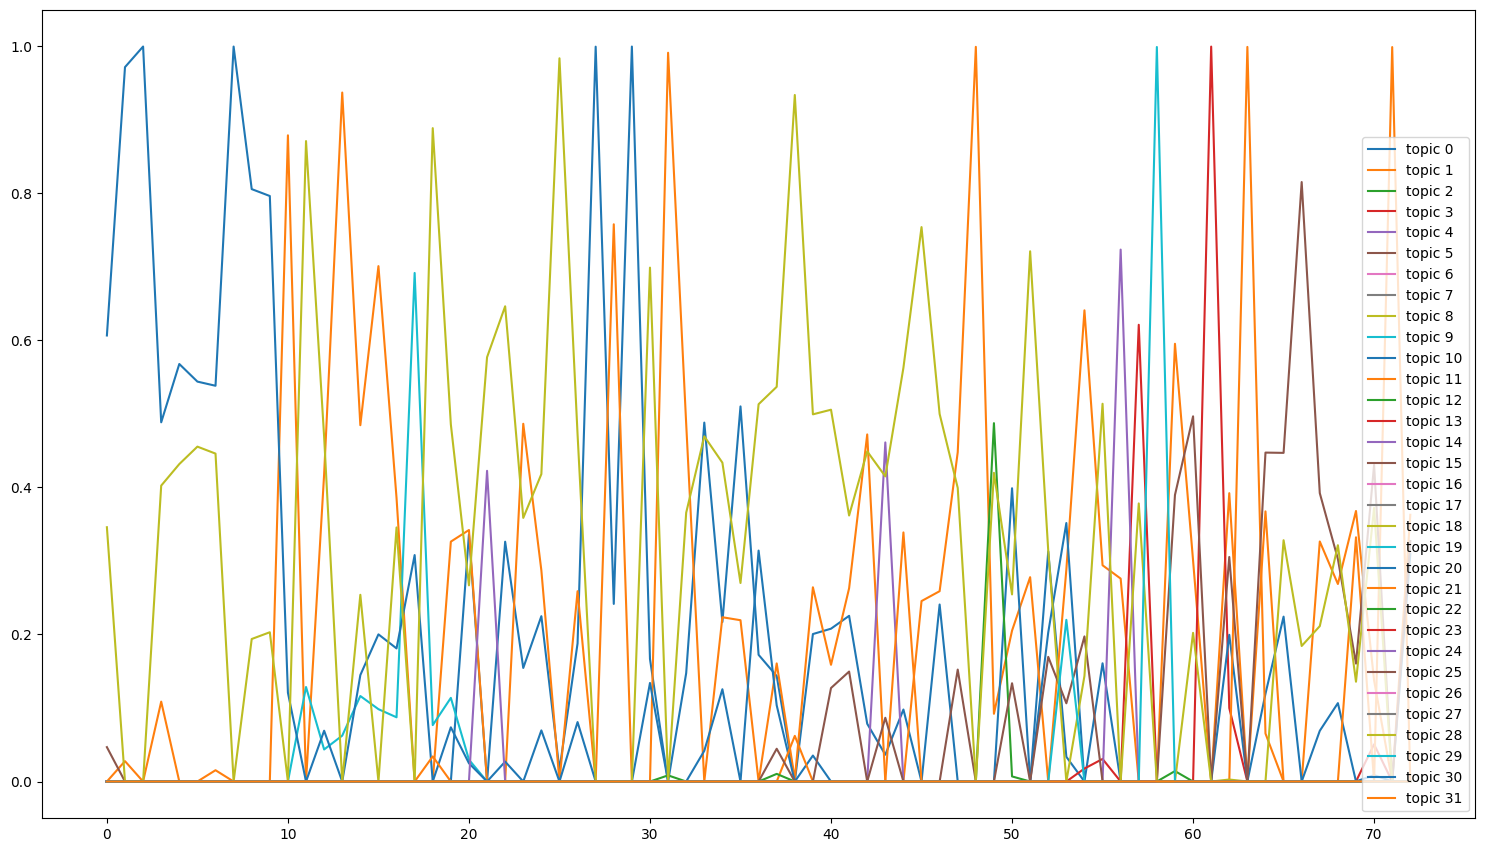

In [ ]:
import matplotlib.pyplot as plt

#major_topics_only = True
major_topics_only = False

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

time = np.arange(len(dataset))
for i, topic_evolution in enumerate(np.transpose(lda_model.transform(matrix))):
    if(major_topics_only and (i not in major_topics)): continue # Filters out the topics that are not major ones.
    ax.plot(time, topic_evolution, label=f"topic {i}")

ax.legend(loc='lower right')
plt.show()

We use here the pyLDAvis library (https://pyldavis.readthedocs.io/en/latest/readme.html) to visualise the LDA model.

The interface mainly consist of a left pannel, that spatially organises the topics, and of a right pannel, that shows the vocabulary distribution of one of them.
When a topic is selected, the right pannel shows the forms that are the most "relevant" to this topic.
The notion of relevance used dependens on a parameter λ that can be manually adjusted on top of the pannel and that is described at the bottom of the pannel.
With λ=1, the most relevant forms are the ones that are the most frequently generated by the topic.
With λ=0, the most relevant forms are the ones that are the most specific to the topic.
(Remember that according to the LDA model, multiple topics may generate tokens of the same form.)

Note that the numbering of the topics here is not necessarily the one used above.
This tool sorts the topics by decreasing order of importance in the dataset, the importance of a topic being the number of tokens it has generated in the corpus according to the LDA model.

When using the controlled dataset (and a relevant value for `lda_n_topics`), the topics should roughly be of equal size, rarely overlap, and consists of forms almost all using the same letter.

In [ ]:
try:
    import pyLDAvis
except:
    !pip install pyLDAvis#==3.3.1
    import pyLDAvis

vis_data = pyLDAvis.prepare(topic_term_dists=topic_term_dists, doc_topic_dists=doc_topic_dists, doc_lengths=doc_lengths, vocab=id2form, term_frequency=term_frequency, mds='mmds') # https://pyldavis.readthedocs.io/en/latest/modules/API.html#pyLDAvis.prepare
pyLDAvis.display(vis_data) # Warning: This tool numbers the topics according to their importance in the corpus (in term of number of tokens). It is possible to recognise a topic by looking at the list of forms displayed for λ=1. The list displayed for λ=0 shows the forms that are the most specific to the selected topic.

c:\Users\Wazzat\Desktop\Python\local\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
c:\Users\Wazzat\Desktop\Python\local\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
